In [1]:
import pandas as pd
import numpy as np

In [2]:
from collections import defaultdict
from itertools import chain, combinations

In [3]:
dataset_url = 'http://fimi.uantwerpen.be/data/retail.dat'
data = pd.read_table(dataset_url, header=None)
print(data.head())

                                                   0
0  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1                                          30 31 32 
2                                          33 34 35 
3                  36 37 38 39 40 41 42 43 44 45 46 
4                                       38 39 47 48 


In [4]:
np_data = data.to_numpy()
itemSetList = []
for record in np_data:
    itemSetList.append(np.fromstring(record[0], dtype=int, sep=" "))

In [5]:
print(itemSetList[:5])
print(len(itemSetList))

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([30, 31, 32]), array([33, 34, 35]), array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]), array([38, 39, 47, 48])]
88162


### Apriori

The following are the main steps of the apriori algorithm:

- Calculate the support of item sets (of size k = 1) in the transactional database (note that support is the frequency of occurrence of an itemset). This is called generating the candidate set.

- Prune the candidate set by eliminating items with a support less than the given threshold.

- Join the frequent itemsets to form sets of size k + 1, and repeat the above sets until no more itemsets can be formed. This will happen when the set(s) formed have a support less than the given support.

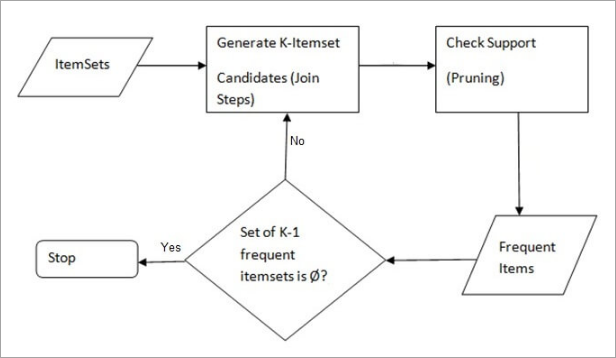

Modifications

- Transaction reduction: Traditional Apriori algorithm involves the generation of many candidate item sets consisting of many infrequent and unnecessary item sets, and a large number of combinations. The algorithm was modified to disregard itemsets with frequency less than a threshold using minimum support and minimum confidence criteria, and only most frequent itemsets were considered for further rule generation, greatly increasing the efficiency of the algorithm.
- Sampling: The algorithm when run on randomly selected sample of the entire database gave similar results, as itemsets frequent in the entire database are likely to be frequent in the sample as well.

In [6]:
def apriori(itemSetList, minSup, minConf):
    itemSet = getItemSetFromList(itemSetList)
    # Final result, global frequent itemset
    globalFreqItemSet = dict()
    # Storing global itemset with support count
    globalItemSetWithSup = defaultdict(int)

    print('Scan ',1)
    currentLSet = getAboveMinSup(itemSet, itemSetList, minSup, globalItemSetWithSup)
    print('Size of freq set: ', len(currentLSet))
    k = 2

    # Calculating frequent item set
    while(currentLSet):
        # Storing frequent itemset
        globalFreqItemSet[k-1] = currentLSet
        # Self-joining Lk
        candidateSet = getUnion(currentLSet, k)
        # Perform subset testing and remove pruned supersets
        candidateSet = pruning(candidateSet, currentLSet, k-1)
        # Scanning itemSet for counting support
        print('Scan ',k)
        currentLSet = getAboveMinSup(candidateSet, itemSetList, minSup, globalItemSetWithSup)
        print('Size of freq set: ', len(currentLSet))
        k += 1

    rules = associationRuleAP(globalFreqItemSet, globalItemSetWithSup, minConf)
    rules.sort(key=lambda x: x[2])

    #print(globalFreqItemSet)
    
    return globalFreqItemSet, rules

In [7]:
def getItemSetFromList(itemSetList):
    tempItemSet = set()

    for itemSet in itemSetList:
        for item in itemSet:
            tempItemSet.add(frozenset([item]))

    return tempItemSet

In [8]:
def getUnion(itemSet, length):
    return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])

In [9]:
def pruning(candidateSet, prevFreqSet, length):
    tempCandidateSet = candidateSet.copy()
    for item in candidateSet:
        subsets = combinations(item, length)
        for subset in subsets:
            # if the subset is not in previous K-frequent get, then remove the set
            if(frozenset(subset) not in prevFreqSet):
                tempCandidateSet.remove(item)
                break
    return tempCandidateSet

In [10]:
def getAboveMinSup(itemSet, itemSetList, minSup, globalItemSetWithSup):
    freqItemSet = set()
    localItemSetWithSup = defaultdict(int)

    for item in itemSet:
        for itemSet in itemSetList:
            if item.issubset(itemSet):
                globalItemSetWithSup[item] += 1
                localItemSetWithSup[item] += 1

    for item, supCount in localItemSetWithSup.items():
        support = float(supCount / len(itemSetList))
        if(support >= minSup):
            freqItemSet.add(item)

    return freqItemSet

In [11]:
def associationRuleAP(freqItemSet, itemSetWithSup, minConf):
    rules = []
    for k, itemSet in freqItemSet.items():
        for item in itemSet:
            subsets = powerset(item)
            for s in subsets:
                confidence = float(
                    itemSetWithSup[item] / itemSetWithSup[frozenset(s)])
                if(confidence > minConf):
                    rules.append([set(s), set(item.difference(s)), confidence])
    return rules

In [12]:
def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

### FP Growth

Frequent Pattern Tree is a tree-like structure that is made with the initial itemsets of the database. The purpose of the FP tree is to mine the most frequent pattern. Each node of the FP tree represents an item of the itemset.

The root node represents null while the lower nodes represent the itemsets. The association of the nodes with the lower nodes that is the itemsets with the other itemsets are maintained while forming the tree.

In [13]:
def fpgrowth(itemSetList, minSupRatio, minConf):
    frequency = getFrequencyFromList(itemSetList)
    minSup = len(itemSetList) * minSupRatio
    fpTree, headerTable = constructTree(itemSetList, frequency, minSup)
    if(fpTree == None):
        print('No frequent item set')
    else:
        freqItems = []
        mineTree(headerTable, minSup, set(), freqItems)
        rules = associationRuleFP(freqItems, itemSetList, minConf)
        return freqItems, rules

In [14]:
class Node:
    def __init__(self, itemName, frequency, parentNode):
        self.itemName = itemName
        self.count = frequency
        self.parent = parentNode
        self.children = {}
        self.next = None

    def increment(self, frequency):
        self.count += frequency

    def display(self, ind=1):
        print('  ' * ind, self.itemName, ' ', self.count)
        for child in list(self.children.values()):
            child.display(ind+1)

In [15]:
def constructTree(itemSetList, frequency, minSup):
    headerTable = defaultdict(int)
    # Counting frequency and create header table
    for idx, itemSet in enumerate(itemSetList):
        for item in itemSet:
            headerTable[item] += frequency[idx]

    # Deleting items below minSup
    headerTable = dict((item, sup) for item, sup in headerTable.items() if sup >= minSup)
    if(len(headerTable) == 0):
        return None, None

    # HeaderTable column [Item: [frequency, headNode]]
    for item in headerTable:
        headerTable[item] = [headerTable[item], None]

    # Init Null head node
    fpTree = Node('Null', 1, None)
    # Update FP tree for each cleaned and sorted itemSet
    for idx, itemSet in enumerate(itemSetList):
        itemSet = [item for item in itemSet if item in headerTable]
        itemSet.sort(key=lambda item: headerTable[item][0], reverse=True)
        # Traverse from root to leaf, update tree with given item
        currentNode = fpTree
        for item in itemSet:
            currentNode = updateTree(item, currentNode, headerTable, frequency[idx])

    return fpTree, headerTable

In [16]:
def updateHeaderTable(item, targetNode, headerTable):
    if(headerTable[item][1] == None):
        headerTable[item][1] = targetNode
    else:
        currentNode = headerTable[item][1]
        # Traverse to the last node then link it to the target
        while currentNode.next != None:
            currentNode = currentNode.next
        currentNode.next = targetNode

def updateTree(item, treeNode, headerTable, frequency):
    if item in treeNode.children:
        # If the item already exists, increment the count
        treeNode.children[item].increment(frequency)
    else:
        # Create a new branch
        newItemNode = Node(item, frequency, treeNode)
        treeNode.children[item] = newItemNode
        # Link the new branch to header table
        updateHeaderTable(item, newItemNode, headerTable)

    return treeNode.children[item]

In [17]:
def ascendFPtree(node, prefixPath):
    if node.parent != None:
        prefixPath.append(node.itemName)
        ascendFPtree(node.parent, prefixPath)

def findPrefixPath(basePat, headerTable):
    # First node in linked list
    treeNode = headerTable[basePat][1] 
    condPats = []
    frequency = []
    while treeNode != None:
        prefixPath = []
        # From leaf node all the way to root
        ascendFPtree(treeNode, prefixPath)  
        if len(prefixPath) > 1:
            # Storing the prefix path and it's corresponding count
            condPats.append(prefixPath[1:])
            frequency.append(treeNode.count)

        # Go to next node
        treeNode = treeNode.next  
    return condPats, frequency

def mineTree(headerTable, minSup, preFix, freqItemList):
    # Sort the items with frequency and create a list
    sortedItemList = [item[0] for item in sorted(list(headerTable.items()), key=lambda p:p[1][0])] 
    # Start with the lowest frequency
    for item in sortedItemList:  
        # Pattern growth is achieved by the concatenation of suffix pattern with frequent patterns generated from conditional FP-tree
        newFreqSet = preFix.copy()
        newFreqSet.add(item)
        freqItemList.append(newFreqSet)
        # Find all prefix path, constrcut conditional pattern base
        conditionalPattBase, frequency = findPrefixPath(item, headerTable) 
        # Construct conditonal FP Tree with conditional pattern base
        conditionalTree, newHeaderTable = constructTree(conditionalPattBase, frequency, minSup) 
        if newHeaderTable != None:
            # Mining recursively on the tree
            mineTree(newHeaderTable, minSup,
                       newFreqSet, freqItemList)

In [18]:
def getSupport(testSet, itemSetList):
    count = 0
    for itemSet in itemSetList:
        if(set(testSet).issubset(itemSet)):
            count += 1
    return count

def getFrequencyFromList(itemSetList):
    frequency = [1 for i in range(len(itemSetList))]
    return frequency

In [19]:
def associationRuleFP(freqItemSet, itemSetList, minConf):
    rules = []
    for itemSet in freqItemSet:
        subsets = powerset(itemSet)
        itemSetSup = getSupport(itemSet, itemSetList)
        for s in subsets:
            confidence = float(itemSetSup / getSupport(s, itemSetList))
            if(confidence > minConf):
                rules.append([set(s), set(itemSet.difference(s)), confidence])
    return rules

### Test

The functions apriori and fpgrowth each takes in the dataset and thresholds for support and confidence as parameters and returns the most frequent itemsets along with the association rules derived from those itemsets. 

In [20]:
(globalFreqItemSetAP, rulesAP) = apriori(itemSetList,0.01,0.2)

Scan  1
Size of freq set:  70
Scan  2
Size of freq set:  58
Scan  3
Size of freq set:  25
Scan  4
Size of freq set:  6
Scan  5
Size of freq set:  0


In [21]:
(globalFreqItemSetFP, rulesFP) = fpgrowth(itemSetList,0.01,0.2)

In [22]:
print(rulesAP)
print(globalFreqItemSetAP)

[[{48, 38, 39}, {32}, 0.2025565388397247], [{39}, {38}, 0.20414405525407006], [{41}, {38, 39}, 0.20414854466376714], [{32, 48}, {38}, 0.2048792631316903], [{32, 48}, {41, 39}, 0.2048792631316903], [{41, 39}, {32}, 0.20667601191519186], [{48, 38}, {32}, 0.20720040281973817], [{48, 39}, {38}, 0.20938851142680667], [{32}, {41}, 0.2107206435023406], [{41}, {32}, 0.2138507862161258], [{48}, {41}, 0.2140263438946244], [{32, 39}, {38}, 0.21762270845653459], [{48, 41}, {38, 39}, 0.22078066090042137], [{65}, {41}, 0.22249552772808587], [{48, 41, 39}, {32}, 0.22345913657344557], [{39}, {41}, 0.22523926985693143], [{48, 41}, {32}, 0.22876469283654913], [{32, 48, 39}, {38}, 0.22880414661236578], [{38}, {41}, 0.2498717619902539], [{48, 38}, {41, 39}, 0.2506294058408862], [{48, 39}, {41}, 0.2527623361471416], [{32, 48}, {41}, 0.2567836694050286], [{41}, {38}, 0.2607561057209769], [{48, 41}, {38}, 0.2632512752273231], [{41, 39}, {38}, 0.26730331172244615], [{48, 41, 39}, {38}, 0.2702959543850122], [{

In [23]:
print(rulesFP)
print(globalFreqItemSetFP)

[[{37}, {38}, 0.9739292364990689], [{286}, {38}, 0.9433643279797126], [{1146}, {39}, 0.6893408134642356], [{12925}, {39}, 0.6394001363326517], [{255}, {48}, 0.7170963364993216], [{255}, {39}, 0.7170963364993216], [{533}, {39}, 0.6200403496973773], [{60}, {39}, 0.6601746138347885], [{79}, {48}, 0.558125], [{79}, {39}, 0.694375], [{2238}, {48}, 0.5568513119533528], [{2238}, {39}, 0.7504373177842566], [{270}, {48}, 0.5519031141868512], [{270}, {39}, 0.6885813148788927], [{147}, {48}, 0.5823496346261945], [{147}, {39}, 0.6391231028667791], [{1327}, {48}, 0.541993281075028], [{1327}, {39}, 0.6472564389697648], [{438}, {48}, 0.5501878690284487], [{438}, {39}, 0.6763285024154589], [{413}, {39}, 0.601063829787234], [{413}, {48}, 0.6037234042553191], [{271}, {48}, 0.5205348615090736], [{271}, {39}, 0.6848137535816619], [{475}, {48}, 0.6589755422242732], [{475}, {48, 39}, 0.5039224734656207], [{48, 475}, {39}, 0.7647058823529411], [{475, 39}, {48}, 0.728], [{475}, {39}, 0.6922011998154131], [{10

### References

- https://towardsdatascience.com/association-rule-mining-be4122fc1793
- https://www.javatpoint.com/apriori-algorithm
- https://www.ijstr.org/final-print/aug2017/A-Modified-Apriori-Algorithm-For-Fast-And-Accurate-Generation-Of-Frequent-Item-Sets.pdf
- https://towardsdatascience.com/the-fp-growth-algorithm-1ffa20e839b8
- https://towardsdatascience.com/association-rules-2-aa9a77241654